In [1]:
import h5py
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from math import sqrt
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/stock_data.h5', 'r') as f:
    # apple
    X_train_apple = torch.tensor(f['X_train_apple'][:], dtype=torch.float32)
    y_train_apple = torch.tensor(f['y_train_apple'][:], dtype=torch.float32)
    X_val_apple = torch.tensor(f['X_val_apple'][:], dtype=torch.float32)
    y_val_apple = torch.tensor(f['y_val_apple'][:], dtype=torch.float32)
    X_test_apple = torch.tensor(f['X_test_apple'][:], dtype=torch.float32)
    y_test_apple = torch.tensor(f['y_test_apple'][:], dtype=torch.float32)

    # google
    X_train_google = torch.tensor(f['X_train_google'][:], dtype=torch.float32)
    y_train_google = torch.tensor(f['y_train_google'][:], dtype=torch.float32)
    X_val_google = torch.tensor(f['X_val_google'][:], dtype=torch.float32)
    y_val_google = torch.tensor(f['y_val_google'][:], dtype=torch.float32)
    X_test_google = torch.tensor(f['X_test_google'][:], dtype=torch.float32)
    y_test_google = torch.tensor(f['y_test_google'][:], dtype=torch.float32)

    # tesla
    X_train_tesla = torch.tensor(f['X_train_tesla'][:], dtype=torch.float32)
    y_train_tesla = torch.tensor(f['y_train_tesla'][:], dtype=torch.float32)
    X_val_tesla = torch.tensor(f['X_val_tesla'][:], dtype=torch.float32)
    y_val_tesla = torch.tensor(f['y_val_tesla'][:], dtype=torch.float32)
    X_test_tesla = torch.tensor(f['X_test_tesla'][:], dtype=torch.float32)
    y_test_tesla = torch.tensor(f['y_test_tesla'][:], dtype=torch.float32)

# dataloader
train_loader_apple = DataLoader(TensorDataset(X_train_apple, y_train_apple), batch_size=64, shuffle=True)
val_loader_apple = DataLoader(TensorDataset(X_val_apple, y_val_apple), batch_size=64, shuffle=False)
test_loader_apple = DataLoader(TensorDataset(X_test_apple, y_test_apple), batch_size=64, shuffle=False)

train_loader_google = DataLoader(TensorDataset(X_train_google, y_train_google), batch_size=64, shuffle=True)
val_loader_google = DataLoader(TensorDataset(X_val_google, y_val_google), batch_size=64, shuffle=False)
test_loader_google = DataLoader(TensorDataset(X_test_google, y_test_google), batch_size=64, shuffle=False)

train_loader_tesla = DataLoader(TensorDataset(X_train_tesla, y_train_tesla), batch_size=64, shuffle=True)
val_loader_tesla = DataLoader(TensorDataset(X_val_tesla, y_val_tesla), batch_size=64, shuffle=False)
test_loader_tesla = DataLoader(TensorDataset(X_test_tesla, y_test_tesla), batch_size=64, shuffle=False)


In [3]:
class Attention(nn.Module):
    def __init__(self, hidden_layer_size):
        super(Attention, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.attention = nn.Linear(self.hidden_layer_size, 1)

    def forward(self, x):
        attention_scores = self.attention(x)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = attention_weights * x
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights


In [4]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.2):
        super(StockPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.attention = Attention(hidden_layer_size)

        # Initialize LSTM with the dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Initialize Dense layer with He initialization
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)
        nn.init.kaiming_normal_(self.linear.weight, mode='fan_out', nonlinearity='leaky_relu')

        # Leaky ReLU activation
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
      # Initialize hidden state and cell state
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

      # Forward propagate LSTM
      lstm_out, _ = self.lstm(x, (h0, c0))

      # Get the context vector from the attention layer
      context_vector, attention_weights = self.attention(lstm_out)
      out = lstm_out[:, -1, :]  # Get the last time step output from LSTM

      # Apply Leaky ReLU activation
      out = self.leaky_relu(out)

      # Pass through the linear layer
      combined_out = torch.cat((out, context_vector), 1)
      out = self.linear(combined_out)
      return out, attention_weights  # Make sure to return both output and attention weights



In [9]:
def cross_validate(model_class, dataset, k_folds, l2_penalties):
    # Initialise K-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True)

    # Record the average validation loss for each regularisation parameter
    avg_val_losses = {}

    # For each L2 regularised intensity
    for l2_penalty in l2_penalties:
        print(f"Testing L2 penalty: {l2_penalty}")
        val_losses = []  # Save the validation losses for each fold

        # Perform k-fold cross validation
        for fold, (train_ids, val_ids) in enumerate(kf.split(dataset)):
            print(f"Folding {fold+1}/{k_folds}")
            # Split the data
            X_train_fold = dataset.tensors[0][train_ids]
            y_train_fold = dataset.tensors[1][train_ids]
            X_val_fold = dataset.tensors[0][val_ids]
            y_val_fold = dataset.tensors[1][val_ids]

            # Create the data loader
            train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=64, shuffle=True)
            val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=64, shuffle=False)

            # Initialise the model
            model = model_class(input_size, hidden_layer_size, num_layers, output_size)

            trained_model, train_losses, fold_val_losses = train_and_validate(
                model, train_loader, val_loader, num_epochs=10, weight_decay=l2_penalty)

            # Record the average validation loss for this fold
            avg_fold_val_loss = sum(fold_val_losses) / len(fold_val_losses)
            val_losses.append(avg_fold_val_loss)

        # Calculate the average validation loss for this L2 regularisation parameter
        avg_val_losses[l2_penalty] = sum(val_losses) / len(val_losses)

    # Return the L2 regularisation parameter with the lowest average validation loss
    best_l2_penalty = min(avg_val_losses, key=avg_val_losses.get)
    return best_l2_penalty, avg_val_losses

In [6]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.val_loss_min = val_loss

def train_and_validate(model, train_loader, val_loader, num_epochs=50, weight_decay=0.01):
    criterion = nn.MSELoss()

    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-5, verbose=True)
    # Early stop
    early_stopping = EarlyStopping(patience=50, verbose=True)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training modalities
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs, attention_weights = model(X_batch)  # Get outputs and attention weights
            outputs = outputs  # Only use outputs for loss calculation

            loss = criterion(outputs, y_batch.view(y_batch.size(0), -1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Evaluation model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs, attention_weights = model(X_batch)  # Get outputs and attention weights
                outputs = outputs  # Only use outputs for loss calculation

                loss = criterion(outputs, y_batch.view(y_batch.size(0), -1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Updated early stop method and learning rate scheduler
        early_stopping(avg_val_loss, model)
        scheduler.step(avg_val_loss)

        if early_stopping.early_stop:
            print("Early Stop")
            break

    # Load optimal model weights
    model.load_state_dict(torch.load('checkpoint.pth'))

    return model, train_losses, val_losses



In [11]:
# Initialize the model, loss function and optimizer
input_size = X_train_apple.shape[2]
hidden_layer_size = 100
num_layers = 2
output_size = y_train_apple.shape[2] * y_train_apple.shape[1]

In [12]:
l2_penalties = [0.0001, 0.001, 0.01, 0.1, 1.0]
# Cross-validation of Apple's dataset
dataset_apple = TensorDataset(X_train_apple, y_train_apple)
best_penalty_apple, validation_results_apple = cross_validate(
    StockPredictor, dataset_apple, 5, l2_penalties)


# Cross-validation of Google Inc. datasets
dataset_google = TensorDataset(X_train_google, y_train_google)
best_penalty_google, validation_results_google = cross_validate(
    StockPredictor, dataset_google, 5, l2_penalties)


# Cross-validation of Tesla Inc. datasets
dataset_tesla = TensorDataset(X_train_tesla, y_train_tesla)
best_penalty_tesla, validation_results_tesla = cross_validate(
    StockPredictor, dataset_tesla, 5, l2_penalties)

print(f"Best L2 penalty for Apple: {best_penalty_apple}")
print(f"Best L2 penalty for Google: {best_penalty_google}")
print(f"Best L2 penalty for Tesla: {best_penalty_tesla}")


Testing L2 penalty: 0.0001
Folding 1/5
Epoch [1/10], Train Loss: 0.1703, Val Loss: 0.2716
Validation loss decreased (inf --> 0.271637).  Saving model ...
Epoch [2/10], Train Loss: 0.1441, Val Loss: 0.2350
Validation loss decreased (0.271637 --> 0.235016).  Saving model ...
Epoch [3/10], Train Loss: 0.1179, Val Loss: 0.2089
Validation loss decreased (0.235016 --> 0.208879).  Saving model ...
Epoch [4/10], Train Loss: 0.1048, Val Loss: 0.1891
Validation loss decreased (0.208879 --> 0.189095).  Saving model ...
Epoch [5/10], Train Loss: 0.0948, Val Loss: 0.1741
Validation loss decreased (0.189095 --> 0.174121).  Saving model ...
Epoch [6/10], Train Loss: 0.0870, Val Loss: 0.1629
Validation loss decreased (0.174121 --> 0.162916).  Saving model ...
Epoch [7/10], Train Loss: 0.0829, Val Loss: 0.1538
Validation loss decreased (0.162916 --> 0.153784).  Saving model ...
Epoch [8/10], Train Loss: 0.0802, Val Loss: 0.1464
Validation loss decreased (0.153784 --> 0.146393).  Saving model ...
Epoch 

In [18]:
# Train and save the model for Apple
model_apple = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)
model_apple, train_losses_apple, val_losses_apple = train_and_validate(
    model_apple, train_loader_apple, val_loader_apple, num_epochs=500, weight_decay=best_penalty_apple)
torch.save(model_apple.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_apple.pth')

# Train and save the model for Google
model_google = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)
model_google, train_losses_google, val_losses_google = train_and_validate(
    model_google, train_loader_google, val_loader_google, num_epochs=500, weight_decay=best_penalty_google)
torch.save(model_google.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_google.pth')

# Train and save the model for Tesla
model_tesla = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)
model_tesla, train_losses_tesla, val_losses_tesla = train_and_validate(
    model_tesla, train_loader_tesla, val_loader_tesla, num_epochs=500, weight_decay=0.001)
torch.save(model_tesla.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_tesla.pth')

# Saving training and validation losses
with h5py.File('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/training_losses.h5', 'w') as f:
    f.create_dataset('train_losses_apple', data=np.array(train_losses_apple))
    f.create_dataset('val_losses_apple', data=np.array(val_losses_apple))
    f.create_dataset('train_losses_google', data=np.array(train_losses_google))
    f.create_dataset('val_losses_google', data=np.array(val_losses_google))
    f.create_dataset('train_losses_tesla', data=np.array(train_losses_tesla))
    f.create_dataset('val_losses_tesla', data=np.array(val_losses_tesla))

Epoch [1/500], Train Loss: 0.2856, Val Loss: 0.8030
Validation loss decreased (inf --> 0.802952).  Saving model ...
Epoch [2/500], Train Loss: 0.2164, Val Loss: 0.6764
Validation loss decreased (0.802952 --> 0.676416).  Saving model ...
Epoch [3/500], Train Loss: 0.1693, Val Loss: 0.5794
Validation loss decreased (0.676416 --> 0.579447).  Saving model ...
Epoch [4/500], Train Loss: 0.1368, Val Loss: 0.5057
Validation loss decreased (0.579447 --> 0.505654).  Saving model ...
Epoch [5/500], Train Loss: 0.1150, Val Loss: 0.4464
Validation loss decreased (0.505654 --> 0.446379).  Saving model ...
Epoch [6/500], Train Loss: 0.0990, Val Loss: 0.4007
Validation loss decreased (0.446379 --> 0.400651).  Saving model ...
Epoch [7/500], Train Loss: 0.0894, Val Loss: 0.3649
Validation loss decreased (0.400651 --> 0.364861).  Saving model ...
Epoch [8/500], Train Loss: 0.0817, Val Loss: 0.3361
Validation loss decreased (0.364861 --> 0.336087).  Saving model ...
Epoch [9/500], Train Loss: 0.0763, Va

In [ ]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/training_losses.h5', 'r') as f:
    train_losses_apple = np.array(f['train_losses_apple'])
    val_losses_apple = np.array(f['val_losses_apple'])
    train_losses_google = np.array(f['train_losses_google'])
    val_losses_google = np.array(f['val_losses_google'])
    train_losses_tesla = np.array(f['train_losses_tesla'])
    val_losses_tesla = np.array(f['val_losses_tesla'])

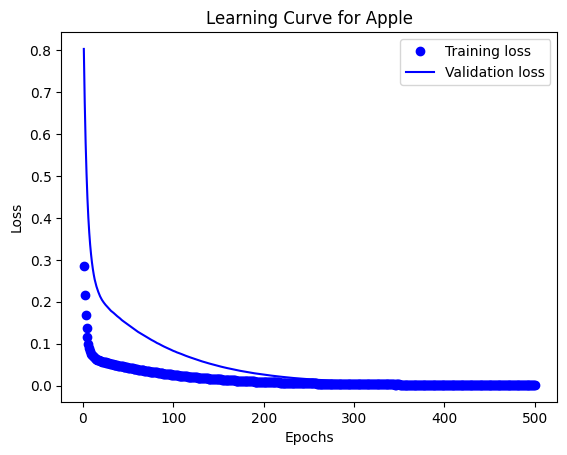

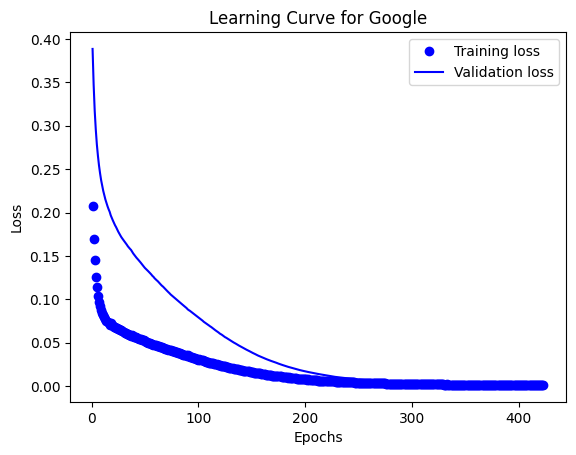

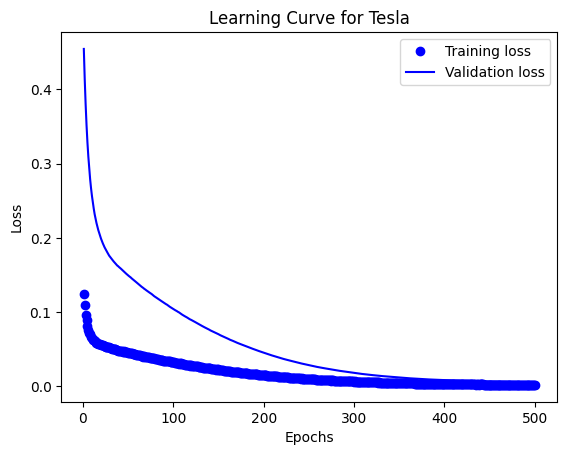

In [19]:
def plot_learning_curves(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_learning_curves(train_losses_apple, val_losses_apple, 'Learning Curve for Apple')
plot_learning_curves(train_losses_google, val_losses_google, 'Learning Curve for Google')
plot_learning_curves(train_losses_tesla, val_losses_tesla, 'Learning Curve for Tesla')

In [20]:
# Load model parameters
model_apple = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)
model_google = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)
model_tesla = StockPredictor(input_size, hidden_layer_size, num_layers, output_size)

model_apple.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_apple.pth'))
model_google.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_google.pth'))
model_tesla.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/model_tesla.pth'))

<All keys matched successfully>

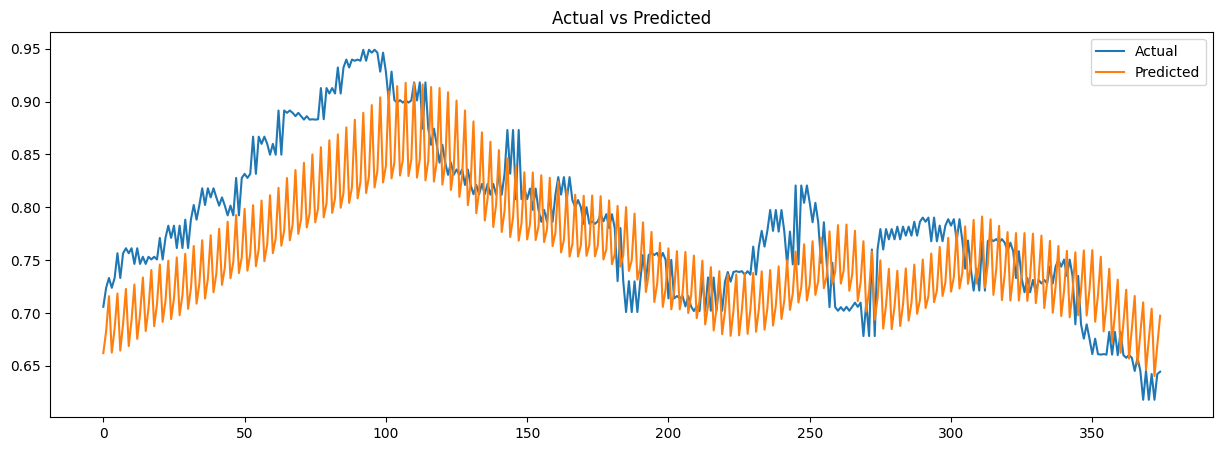

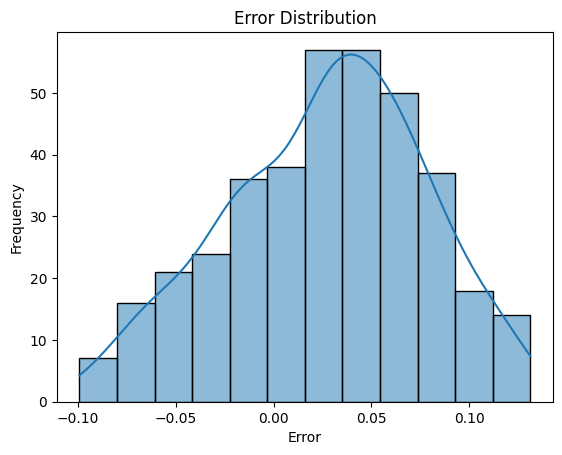

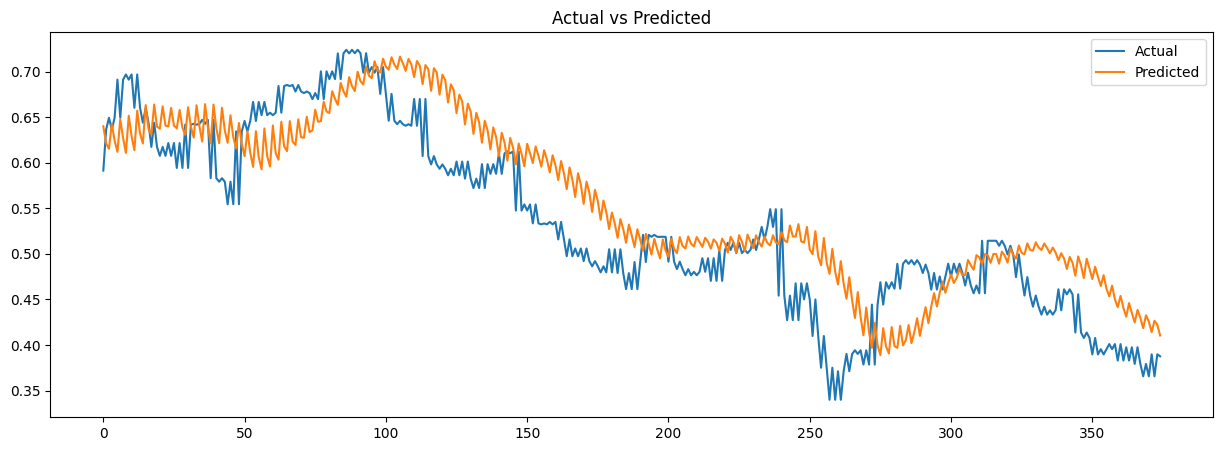

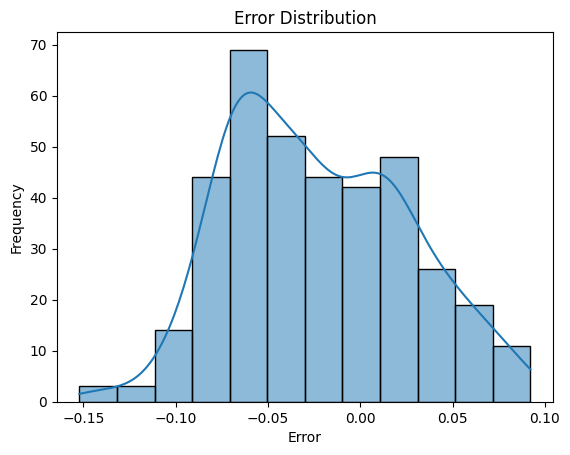

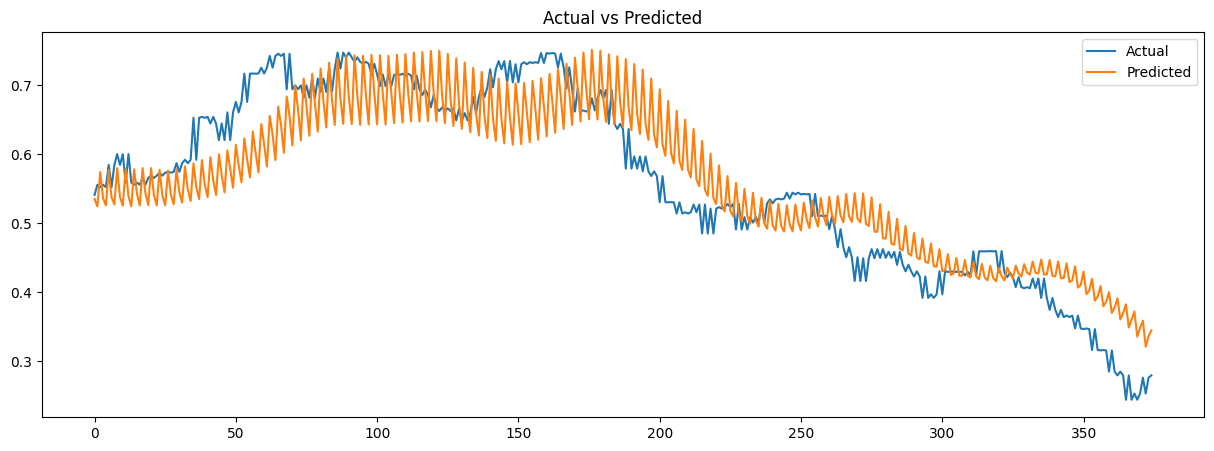

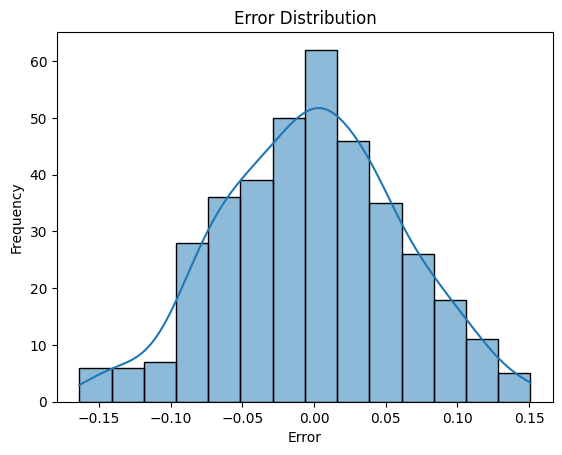

In [21]:
def validate_model(model, X_test, y_test, stock_name):
    model.eval()
    with torch.no_grad():
        predictions, _ = model(X_test)
        predictions = predictions.numpy()

    # Reshape predicted and true values into two-dimensional arrays
    predictions_2d = predictions.reshape(-1, y_test.shape[-1])
    y_test_2d = y_test.numpy().reshape(-1, y_test.shape[-1])

    np.savetxt(f"/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/{stock_name}_predictions.csv", predictions_2d, delimiter=",", header="Predicted_Close,Predicted_Adj_Close", comments="")
    np.savetxt(f"/content/drive/MyDrive/Colab Notebooks/DeepLearning/A3/model_2/{stock_name}_true_values.csv", y_test_2d, delimiter=",", header="True_Close,True_Adj_Close", comments="")

    # Calculate RMSE, MAE, MAPE, and R2 for each feature
    rmses, maes, mapes, r2s = [], [], [], []
    for i in range(predictions_2d.shape[1]):
        mse = mean_squared_error(y_test_2d[:, i], predictions_2d[:, i])
        mae = mean_absolute_error(y_test_2d[:, i], predictions_2d[:, i])
        mape = np.mean(np.abs((y_test_2d[:, i] - predictions_2d[:, i]) / y_test_2d[:, i])) * 100
        r2 = r2_score(y_test_2d[:, i], predictions_2d[:, i])

        rmse = sqrt(mse)
        rmses.append(rmse)
        maes.append(mae)
        mapes.append(mape)
        r2s.append(r2)

    # Plotting of actual versus predicted values
    plt.figure(figsize=(15, 5))
    plt.plot(y_test_2d[:, 0], label='Actual')
    plt.plot(predictions_2d[:, 0], label='Predicted')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

    # Error distribution analysis
    sns.histplot(y_test_2d[:, 0] - predictions_2d[:, 0], kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

    # Calculate total RMSE, MAE, MAPE and R2
    total_rmse = sqrt(mean_squared_error(y_test_2d, predictions_2d))
    total_mae = mean_absolute_error(y_test_2d, predictions_2d)
    total_mape = np.mean(np.abs((y_test_2d - predictions_2d) / y_test_2d)) * 100
    total_r2 = r2_score(y_test_2d, predictions_2d)

    return rmses, total_rmse, maes, total_mae, mapes, total_mape, r2s, total_r2

# Evaluate Apple's model
rmses_apple, total_rmse_apple, maes_apple, total_mae_apple, mapes_apple, total_mape_apple, r2s_apple, total_r2_apple = validate_model(model_apple, X_test_apple, y_test_apple, 'apple')

# Evaluate Google's models
rmses_google, total_rmse_google, maes_google, total_mae_google, mapes_google, total_mape_google, r2s_google, total_r2_google = validate_model(model_google, X_test_google, y_test_google, 'google')

# Evaluate Tesla's models
rmses_tesla, total_rmse_tesla, maes_tesla, total_mae_tesla, mapes_tesla, total_mape_tesla, r2s_tesla, total_r2_tesla = validate_model(model_tesla, X_test_tesla, y_test_tesla, 'tesla')



In [22]:
# Print Apple's evaluation results
print("Apple Stock:")
print("Feature-wise RMSE:", rmses_apple)
print("Total RMSE:", total_rmse_apple)
print("Feature-wise MAE:", maes_apple)
print("Total MAE:", total_mae_apple)
print("Feature-wise MAPE:", mapes_apple)
print("Total MAPE:", total_mape_apple)
print("Feature-wise R-squared:", r2s_apple)
print("Total R-squared:", total_r2_apple)
print("\n")

# Print Google's assessment results
print("Google Stock:")
print("Feature-wise RMSE:", rmses_google)
print("Total RMSE:", total_rmse_google)
print("Feature-wise MAE:", maes_google)
print("Total MAE:", total_mae_google)
print("Feature-wise MAPE:", mapes_google)
print("Total MAPE:", total_mape_google)
print("Feature-wise R-squared:", r2s_google)
print("Total R-squared:", total_r2_google)
print("\n")

# Print Tesla's evaluation results
print("Tesla Stock:")
print("Feature-wise RMSE:", rmses_tesla)
print("Total RMSE:", total_rmse_tesla)
print("Feature-wise MAE:", maes_tesla)
print("Total MAE:", total_mae_tesla)
print("Feature-wise MAPE:", mapes_tesla)
print("Total MAPE:", total_mape_tesla)
print("Feature-wise R-squared:", r2s_tesla)
print("Total R-squared:", total_r2_tesla)

Apple Stock:
Feature-wise RMSE: [0.05698285221175979, 0.04680693174447144]
Total RMSE: 0.05214371856312203
Feature-wise MAE: [0.04788399, 0.03974662]
Total MAE: 0.043815292
Feature-wise MAPE: [6.0228850692510605, 4.993320629000664]
Total MAPE: 5.508102476596832
Feature-wise R-squared: [0.3752314056716264, 0.5709118741491747]
Total R-squared: 0.47307163906282795


Google Stock:
Feature-wise RMSE: [0.05364345516138587, 0.05323301223304356]
Total RMSE: 0.053438625578291654
Feature-wise MAE: [0.045366887, 0.04460197]
Total MAE: 0.044984423
Feature-wise MAPE: [9.111707657575607, 9.044840186834335]
Total MAPE: 9.078273177146912
Feature-wise R-squared: [0.7044006500343775, 0.7089067645751481]
Total R-squared: 0.7066537073047627


Tesla Stock:
Feature-wise RMSE: [0.06173511639719247, 0.05573050607463581]
Total RMSE: 0.0588094951442734
Feature-wise MAE: [0.04957443, 0.045695484]
Total MAE: 0.047634967
Feature-wise MAPE: [9.617935121059418, 9.010045230388641]
Total MAPE: 9.31398943066597
Feature

### Apple Stock Model Comparison

| Metric      | Model 2 Feature-wise   | Model 2 Total  | Model 1 Feature-wise   | Model 1 Total  |
|-------------|------------------------|----------------|------------------------|----------------|
| RMSE        | [0.0424, 0.0427]       | 0.0426         | [0.0570, 0.0468]       | 0.0521         |
| MAE         | [0.0351, 0.0354]       | 0.0352         | [0.0479, 0.0397]       | 0.0438         |
| MAPE        | [4.5209, 4.4823]       | 4.5016         | [6.0229, 4.9933]       | 5.5081         |
| R-squared   | [0.6540, 0.6423]       | 0.6482         | [0.3752, 0.5709]       | 0.4731         |

### Google Stock Model Comparison

| Metric      | Model 2 Feature-wise   | Model 2 Total  | Model 1 Feature-wise   | Model 1 Total  |
|-------------|------------------------|----------------|------------------------|----------------|
| RMSE        | [0.0637, 0.0632]       | 0.0634         | [0.0536, 0.0532]       | 0.0534         |
| MAE         | [0.0528, 0.0524]       | 0.0526         | [0.0454, 0.0446]       | 0.0450         |
| MAPE        | [10.7197, 10.6423]     | 10.6810        | [9.1117, 9.0448]       | 9.0783         |
| R-squared   | [0.5837, 0.5895]       | 0.5866         | [0.7044, 0.7089]       | 0.7067         |

### Tesla Stock Model Comparison

| Metric      | Model 2 Feature-wise   | Model 2 Total  | Model 1 Feature-wise   | Model 1 Total  |
|-------------|------------------------|----------------|------------------------|----------------|
| RMSE        | [0.0543, 0.0541]       | 0.0542         | [0.0617, 0.0557]       | 0.0588         |
| MAE         | [0.0442, 0.0440]       | 0.0441         | [0.0496, 0.0457]       | 0.0476         |
| MAPE        | [9.2754, 9.2124]       | 9.2439         | [9.6179, 9.0100]       | 9.3140         |
| R-squared   | [0.8355, 0.8368]       | 0.8362         | [0.7873, 0.8267]       | 0.8070        